In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
from collections import defaultdict

In [2]:
df = pd.read_csv("datos_arreglados.csv", encoding="latin1")
df = df[df["ID"] > 60]

In [3]:
#df.rename(columns={'Ethical technology assessment?':'Ethical technology assessment'}, inplace=True)

bach = df[df['program'] == 'bachelor'] #selecciona las tuplas de bachelor en un df
mast = df[df['program'] == 'master'] #selecciona las tuplas master en un df

b_aal = bach[bach['campus'] == 'AAL'] #selecciona las tuplas bachelor aal en df
m_aal = mast[mast['campus'] == 'AAL'] #selecciona las tuplas master aal en df

b_cph = bach[bach['campus'] == 'CPH'] #selecciona las tuplas bachelor cph en df
m_cph = mast[mast['campus'] == 'CPH'] #selecciona las tuplas master cph en df

esb = df[df['campus'] == 'ESB'] #selecciona las tuplas esb en df

In [4]:
col1 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most4' 
col2 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most5'
col3 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most6'

cursos_b_aal = list(set(b_aal[col1]) | set(b_aal[col2]) | set(b_aal[col3])) #talleres disponibles para bachelor aal, en base a los seleccionados en top 3
cursos_m_aal = list(set(m_aal[col1]) | set(m_aal[col2]) | set(m_aal[col3])) #talleres disponibles para master aal,  en base a los seleccionados en top 3

pref_b_aal = b_aal[cursos_b_aal] #selecciona columnas de los nombres de curso, donde cada columna posee NaN, 1, 2, 3 indicando preferencia top 3 o no
pref_m_aal = m_aal[cursos_m_aal]  #selecciona columnas de los nombres de curso, donde cada columna posee NaN, 1, 2, 3 indicando preferencia top 3 o no

In [5]:
def generate_col_nums(data):
    ans = {}
    c = 0
    for col in data.columns:
        ans[col] = c
        c += 1
    return ans

def get_dict(data, row):
    ans = {}
    # PROVISOR #
    ans[1] = 0
    ans[2] = 0
    ans[3] = 0
    names = generate_col_nums(data) #asocia a cada taller un id 0, 1, ...
    #print(names)
    for col in data.columns:
        if not np.isnan(data.iloc[row][col]): #si no es Nan, es decir, si está en su top 3
            ans[int(data.iloc[row][col])] = names[col]
    return ans


In [6]:
#ejemplo:
get_dict(pref_m_aal, 0) #aqui veo las preferencias de la primera fila de master aal

{1: 0, 2: 4, 3: 2}

# Implementación Master Aalborg

In [7]:
n_students = len(pref_m_aal) #number of students in master aal
n_workshops = pref_m_aal.shape[1] #number or workshops in master aal

S = [n for n in range(n_students)] #numera a los students
T = [n for n in range(n_workshops)] #numera a los talleres
H = [0, 1] #AM O PM
#revisar siempre que sea válido, es decir que el total de vacantes para la mañana y para la tarde sean >= que la cantidad de estudiantes
C = [4, 3] #capacidad de talleres por horario, el primero es AM, el segundo PM
U = [150 for n in range(n_workshops)] #capacidades de cada taller, en este caso todos tienen 140 cupos

t_pref = [get_dict(pref_m_aal, n) for n in range(n_students)] #obtiene preferencias top 3 para cada estudiante de master aal

D = [0 for n in range(n_workshops)] #indica 1 si el taller debe ser dictado todo el día, actualmente todos en 0
D[4] = 1 #el taller 4 es todo el día

p = [10, 5, 3] #pesos para cada preferencia

# Para saber preferencia de estudiante s en opcion i. se aplica t_pref[s][i]

In [8]:
for s in S:
    for i in range(3):
        print(f"El estudiante {s}, en la preferencia {i+1} tiene al taller número {t_pref[s][i + 1]}")

El estudiante 0, en la preferencia 1 tiene al taller número 0
El estudiante 0, en la preferencia 2 tiene al taller número 4
El estudiante 0, en la preferencia 3 tiene al taller número 2
El estudiante 1, en la preferencia 1 tiene al taller número 2
El estudiante 1, en la preferencia 2 tiene al taller número 6
El estudiante 1, en la preferencia 3 tiene al taller número 7
El estudiante 2, en la preferencia 1 tiene al taller número 0
El estudiante 2, en la preferencia 2 tiene al taller número 4
El estudiante 2, en la preferencia 3 tiene al taller número 5
El estudiante 3, en la preferencia 1 tiene al taller número 0
El estudiante 3, en la preferencia 2 tiene al taller número 4
El estudiante 3, en la preferencia 3 tiene al taller número 5
El estudiante 4, en la preferencia 1 tiene al taller número 1
El estudiante 4, en la preferencia 2 tiene al taller número 7
El estudiante 4, en la preferencia 3 tiene al taller número 0
El estudiante 5, en la preferencia 1 tiene al taller número 7
El estud

In [9]:
model = Model('m_aal')

###############
## VARIABLES ##
###############

z = model.addVars(T, vtype = GRB.BINARY, name ="z") #1 si el taller i se dicta, 0 si no
y = model.addVars(T, H, vtype=GRB.BINARY, name="y") #1 si el taller i se dicta en el horario h, 0 si no
w = model.addVars(S, T, vtype=GRB.BINARY, name="w") #1 si el estudiante s se asigna al taller i

###################
## RESTRICCIONES ##
###################

## Facility Location
for t in T:
    if (D[t] == 1) : #taller de día completo
        model.addConstr(quicksum(y[t,h] for h in H) == 2*z[t], name=f"full_day_taller[{t}]") #2 si se da, 0 si no
    else:
        model.addConstr(quicksum(y[t,h] for h in H) == z[t], name=f"asign_horario[{t}]") #1 si se da, 0 si no

for h in H:
    model.addConstr(quicksum(y[t, h] for t in T) <= C[h], name=f"capacidad_horario[{h}]") #cantidad de talleres por horario dentro del límite

## Asignación Estudiantes
for s in S:
    model.addConstr(quicksum(w[s, t] for t in T) >= 1, name=f"asign_est[{s}]") #cada estudiante en al menos 1 taller

for t in T:
    model.addConstr(quicksum(w[s, t] for s in S) <= U[t] * z[t], name=f"cap_taller[{t}]") #no se sobrepasa la capacidad del taller si es que este se da

## Asignación Horario REVISARRRRR
for s in S:
    for h in H:
        model.addConstr(quicksum(w[s, t] * y[t, h] for t in T if D[t]==0) <= 1, name=f"conflicto_horario[{s},{h}]") #evita que un estudiante esté en 2 talleres en paralelo


## Talleres Diarios REVISARRRRRR
for t in T:
    for h in H:
        for h2 in H:
            if h != h2:
                model.addConstr(y[t, h] + D[t]*y[t, h2] <= 2, name=f"diario[{t},{h},{h2}]") #max dos horarios para el mismo taller

## Extra
#completar la carga diaria
for s in S:
    #suma de unidades asignadas: medio día=1, día completo=2
    unidades_asignadas = quicksum(w[s,t]*(1+D[t]) for t in T) #revisa cuatas unidades tiene cada estudiante
    
    #todos deben cumplir 2 unidades
    model.addConstr(unidades_asignadas == 2, name=f"completar_2_unidades[{s}]") #asigna 2 unidades a cada estudiante

#solo asigno a talleres que se den, esto es cuando rellena los que no quedaron en top 3
for s in S:
    for t in T:
        model.addConstr(w[s, t] <= z[t], name=f"solo_si_se_dicta[{s},{t}]")

#si el taller es de día completo, lo asigno a ambos módulos
for t in T:
    if D[t] == 1:  # taller de día completo
        model.addConstr(quicksum(y[t,h] for h in H) == 2, name=f"taller_dia-completo[{h},{t}]")




######################
## FUNCIÓN OBJETIVO ##
######################

model.setObjective(quicksum(p[i] * quicksum(w[s, t_pref[s][i + 1]] for s in S) for i in range(3)), GRB.MAXIMIZE)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-10-16


In [10]:
%%time
model.Params.TimeLimit = 1800 #30 min
model.optimize()

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  1800

Optimize a model with 3965 rows, 3168 columns and 15788 nonzeros
Model fingerprint: 0x29988b3e
Model has 786 quadratic constraints
Variable types: 0 continuous, 3168 integer (3168 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
  QRHS range       [1e+00, 1e+00]
Presolve removed 804 rows and 3 columns
Presolve time: 0.03s
Presolved: 9449 rows, 8667 columns, 33840 nonzeros
Variable types: 0 continuous, 8667 integer (8667 binary)

Root relaxation: objective 5.090625e+03, 3793 iterations, 0.15 seconds (0.17 

In [ ]:
#si falla ver la razón
"""
if model.status == GRB.INFEASIBLE:
    print("Modelo es infeasible. Buscando IIS...")
    
    # Computar IIS
    model.computeIIS()
    
    # Mostrar restricciones y variables en conflicto
    print("\nRestricciones en conflicto:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(c.ConstrName)
    
    print("\nVariables involucradas en conflicto:")
    for v in model.getVars():
        if v.IISLB or v.IISUB:
            print(v.VarName)
"""

## Resultados

In [11]:
for i in range(len(z)):
    if (z[i].X) == 1.0:
        print(f"El taller {i} fue elegido para realizarse")
    else:
        print(f"El taller {i} no se realizará")

El taller 0 fue elegido para realizarse
El taller 1 fue elegido para realizarse
El taller 2 fue elegido para realizarse
El taller 3 fue elegido para realizarse
El taller 4 fue elegido para realizarse
El taller 5 no se realizará
El taller 6 fue elegido para realizarse
El taller 7 no se realizará


In [12]:
talleres_AM = []
talleres_PM = []
for key, var in y.items():
    #print(key, var.X)
    if (var.X) == 1.0:
        if (key[1]) == 1:
            print(f"El taller {key[0]} se da en el horario PM")
            talleres_PM.append(key[0])
        else:
            print(f"El taller {key[0]} se da en el horario AM")  
            talleres_AM.append(key[0])

El taller 0 se da en el horario PM
El taller 1 se da en el horario PM
El taller 2 se da en el horario AM
El taller 3 se da en el horario AM
El taller 4 se da en el horario AM
El taller 4 se da en el horario PM
El taller 6 se da en el horario AM


In [13]:
dic_asignaciones_realizadas = {}
e = -1
lista = []
for key, var in w.items():
    if var.X == 1.0:
        #print(key, var.X)
        estudiante = key[0]
        if (estudiante == e):
            lista.append(key[1])
        else:            
            dic_asignaciones_realizadas[e] = lista
            e = estudiante
            lista = []
            lista.append(key[1])
        print(f"El estudiante {key[0]} fue asignado al taller {key[1]}")
del dic_asignaciones_realizadas[-1]

El estudiante 0 fue asignado al taller 0
El estudiante 0 fue asignado al taller 2
El estudiante 1 fue asignado al taller 0
El estudiante 1 fue asignado al taller 2
El estudiante 2 fue asignado al taller 4
El estudiante 3 fue asignado al taller 4
El estudiante 4 fue asignado al taller 1
El estudiante 4 fue asignado al taller 3
El estudiante 5 fue asignado al taller 0
El estudiante 5 fue asignado al taller 6
El estudiante 6 fue asignado al taller 1
El estudiante 6 fue asignado al taller 2
El estudiante 7 fue asignado al taller 1
El estudiante 7 fue asignado al taller 2
El estudiante 8 fue asignado al taller 0
El estudiante 8 fue asignado al taller 6
El estudiante 9 fue asignado al taller 0
El estudiante 9 fue asignado al taller 3
El estudiante 10 fue asignado al taller 0
El estudiante 10 fue asignado al taller 3
El estudiante 11 fue asignado al taller 1
El estudiante 11 fue asignado al taller 2
El estudiante 12 fue asignado al taller 0
El estudiante 12 fue asignado al taller 3
El estudia

In [14]:
print(dic_asignaciones_realizadas) #key: estudiante, value:[talleres asignados]

{0: [0, 2], 1: [0, 2], 2: [4], 3: [4], 4: [1, 3], 5: [0, 6], 6: [1, 2], 7: [1, 2], 8: [0, 6], 9: [0, 3], 10: [0, 3], 11: [1, 2], 12: [0, 3], 13: [1, 2], 14: [4], 15: [1, 3], 16: [0, 6], 17: [1, 2], 18: [0, 3], 19: [1, 3], 20: [1, 3], 21: [1, 2], 22: [4], 23: [1, 6], 24: [4], 25: [4], 26: [0, 6], 27: [1, 2], 28: [0, 6], 29: [0, 6], 30: [0, 6], 31: [0, 6], 32: [0, 2], 33: [0, 2], 34: [1, 3], 35: [1, 6], 36: [0, 6], 37: [4], 38: [0, 6], 39: [0, 6], 40: [1, 6], 41: [1, 2], 42: [1, 6], 43: [0, 2], 44: [0, 6], 45: [4], 46: [1, 2], 47: [0, 3], 48: [4], 49: [4], 50: [4], 51: [0, 2], 52: [0, 6], 53: [4], 54: [0, 3], 55: [1, 6], 56: [0, 3], 57: [1, 3], 58: [1, 2], 59: [0, 3], 60: [1, 2], 61: [4], 62: [1, 2], 63: [4], 64: [1, 6], 65: [0, 6], 66: [1, 6], 67: [0, 6], 68: [0, 6], 69: [4], 70: [1, 6], 71: [0, 6], 72: [1, 6], 73: [1, 2], 74: [1, 2], 75: [4], 76: [1, 3], 77: [4], 78: [0, 2], 79: [1, 6], 80: [1, 2], 81: [4], 82: [1, 6], 83: [1, 2], 84: [0, 6], 85: [4], 86: [1, 2], 87: [4], 88: [0, 6], 8

In [15]:
for key, value in dic_asignaciones_realizadas.items():
    if len(value) != 2:
        print(f"Al estudiante {key} se le asignó taller(es) {value}, verificar si es taller de 1 día completo o fallo")

Al estudiante 2 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 3 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 14 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 22 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 24 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 25 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 37 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 45 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 48 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 49 se le asignó tallere(s) [4], verificar si es taller de 1 día completo o fallo
Al estudiante 50 se le asignó tallere(s) [4], verifi

In [16]:
#contar cuanto se llenó cada taller
capacidad_real_taller = defaultdict(int) #la key es el id del taller 0, 1,... y el value es la cantidad de alumnos asignados a este taller en la solución
for key, value in dic_asignaciones_realizadas.items():
    for taller in value:
       capacidad_real_taller[taller] += 1 

for taller, cantidad in capacidad_real_taller.items():
    print(f"El taller {taller} tiene {cantidad} alumnos, está un {100*(cantidad/U[taller])}% lleno")

El taller 0 tiene 149 alumnos, está un 99.33333333333333% lleno
El taller 2 tiene 124 alumnos, está un 82.66666666666667% lleno
El taller 4 tiene 93 alumnos, está un 62.0% lleno
El taller 1 tiene 150 alumnos, está un 100.0% lleno
El taller 3 tiene 56 alumnos, está un 37.333333333333336% lleno
El taller 6 tiene 119 alumnos, está un 79.33333333333333% lleno


In [17]:
suma_AM = 0
suma_PM = 0
for taller in talleres_AM:
    suma_AM += capacidad_real_taller[taller]
for taller in talleres_PM:
    suma_PM += capacidad_real_taller[taller]
print(suma_AM)
print(suma_PM)

392
392


### Visualizar algunas asignaciones de talleres vs lo que eligió

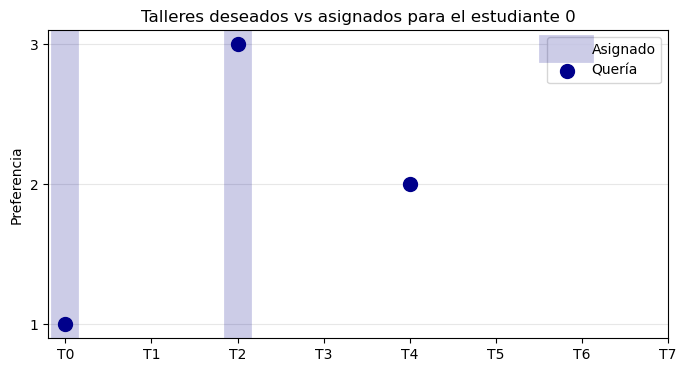

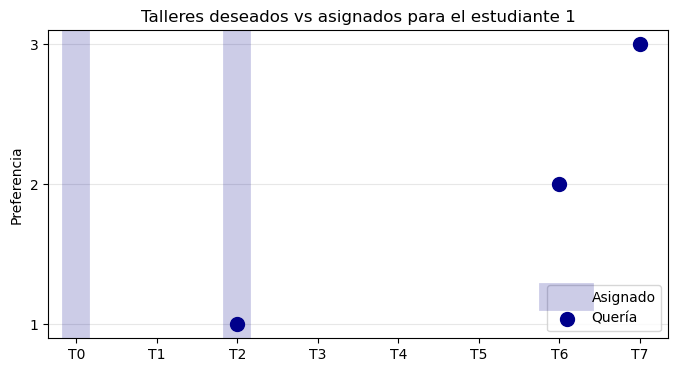

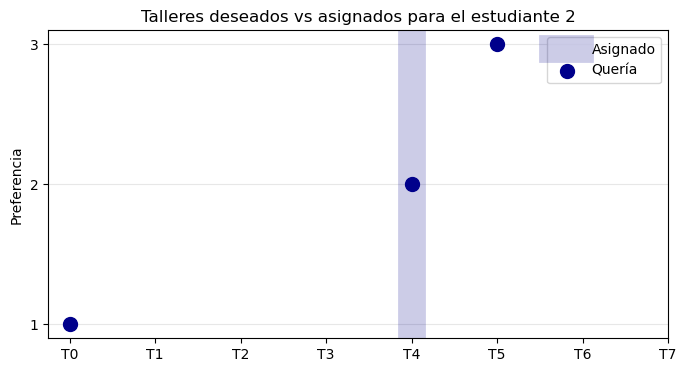

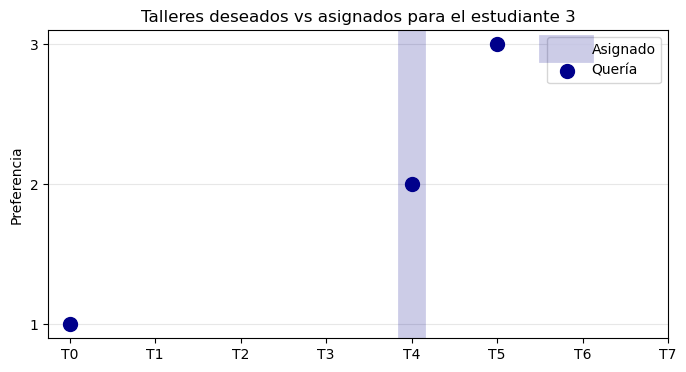

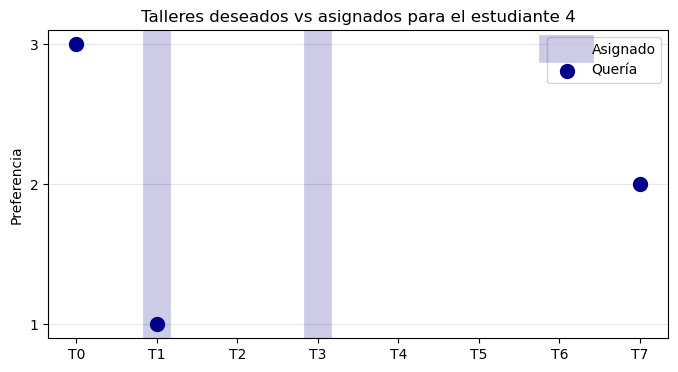

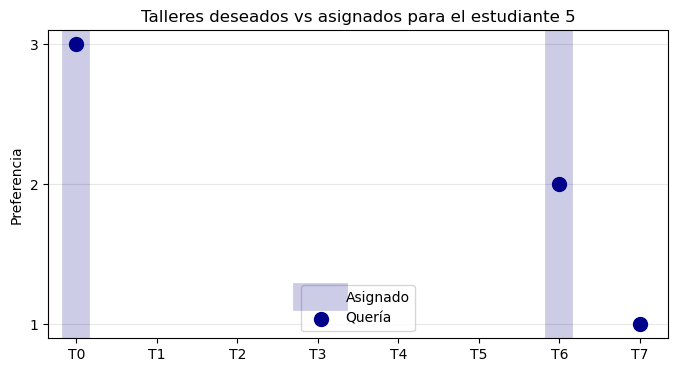

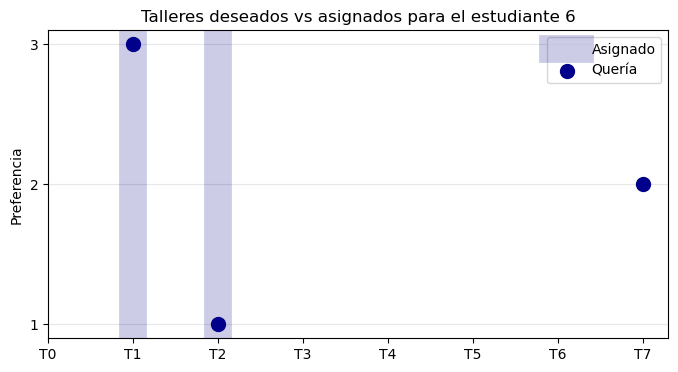

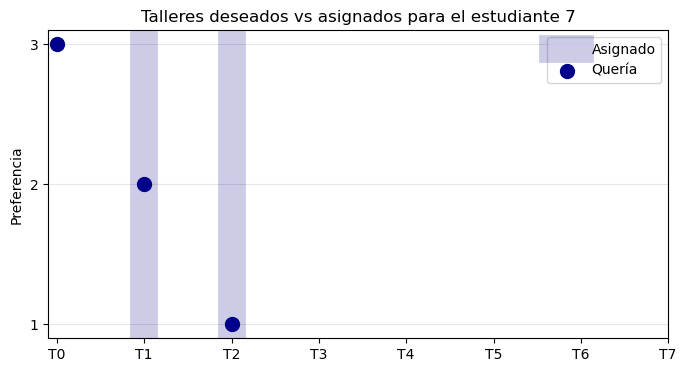

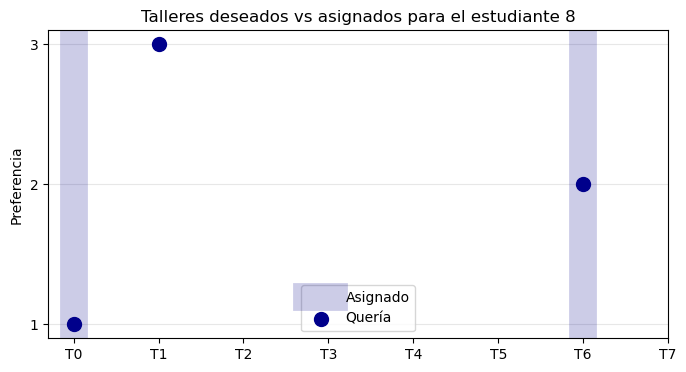

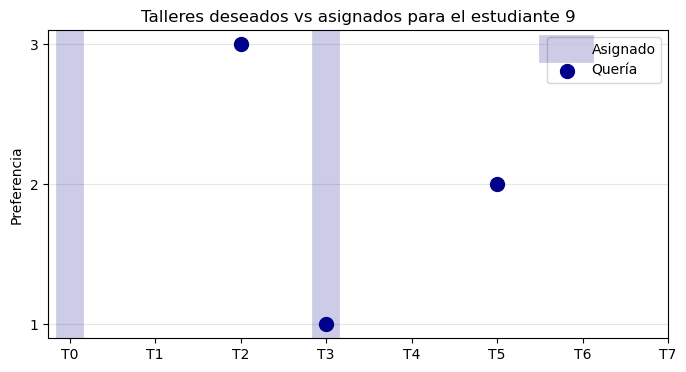

In [18]:
#visualizar la asignación de talleres
talleres = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
#para los estudiantes 0 al 9 muestra los talleres que quería y a los que fue asignado
for i in range(10):
    n_estudiante = i
    preferencias = get_dict(pref_m_aal, n_estudiante) #preferencia, taller
    asignados = dic_asignaciones_realizadas[i] #asignaciones que se les dio
    
    plt.figure(figsize=(8, 4))
    #sombrear las columnas de los talleres asignados
    for t in asignados:
        plt.axvline(x=t, color='darkblue', alpha=0.2, linewidth=20, label='Asignado' if t == asignados[0] else "")
    
    #marcar los puntos de las preferencias
    for pref, t in preferencias.items():
        plt.scatter(t, pref, color='darkblue', s=100, zorder=3, label='Quería' if pref == 1 else "")
    
    plt.xticks(range(len(talleres)), talleres)
    plt.yticks(range(1, 4))
    plt.ylabel('Preferencia')
    plt.title(f'Talleres deseados vs asignados para el estudiante {i}')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()